* https://github.com/MSKCC-Computational-Pathology/MIL-nature-medicine-2019/blob/master/MIL_train.py

* https://github.com/binli123/dsmil-wsi/blob/master/attention_map.py

In [1]:
# -*- coding: utf-8 -*-
import math
import warnings

import torch
from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch.nn import functional as F
from torch.nn import init
from torch.nn.modules.module import Module
from torch.nn.modules.utils import _single, _pair, _triple, _reverse_repeat_tuple
from torch._torch_docs import reproducibility_notes

from torch.nn.common_types import _size_1_t, _size_2_t, _size_3_t
from typing import Optional, List, Tuple, Union

__all__ = ['Conv1d', 'Conv2d', 'Conv3d', 'ConvTranspose1d', 'ConvTranspose2d', 'ConvTranspose3d',
           'LazyConv1d', 'LazyConv2d', 'LazyConv3d', 'LazyConvTranspose1d', 'LazyConvTranspose2d',
           'LazyConvTranspose3d']

convolution_notes = \
    {"groups_note": r"""* :attr:`groups` controls the connections between inputs and outputs.
      :attr:`in_channels` and :attr:`out_channels` must both be divisible by
      :attr:`groups`. For example,

        * At groups=1, all inputs are convolved to all outputs.
        * At groups=2, the operation becomes equivalent to having two conv
          layers side by side, each seeing half the input channels
          and producing half the output channels, and both subsequently
          concatenated.
        * At groups= :attr:`in_channels`, each input channel is convolved with
          its own set of filters (of size
          :math:`\frac{\text{out\_channels}}{\text{in\_channels}}`).""",

        "depthwise_separable_note": r"""When `groups == in_channels` and `out_channels == K * in_channels`,
        where `K` is a positive integer, this operation is also known as a "depthwise convolution".

        In other words, for an input of size :math:`(N, C_{in}, L_{in})`,
        a depthwise convolution with a depthwise multiplier `K` can be performed with the arguments
        :math:`(C_\text{in}=C_\text{in}, C_\text{out}=C_\text{in} \times \text{K}, ..., \text{groups}=C_\text{in})`."""}  # noqa: B950





class _ConvNd(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]) -> Tensor:
        ...

    in_channels: int
    _reversed_padding_repeated_twice: List[int]
    out_channels: int
    kernel_size: Tuple[int, ...]
    stride: Tuple[int, ...]
    padding: Union[str, Tuple[int, ...]]
    dilation: Tuple[int, ...]
    transposed: bool
    output_padding: Tuple[int, ...]
    groups: int
    padding_mode: str
    weight: Tensor
    bias: Optional[Tensor]

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: Tuple[int, ...],
                 stride: Tuple[int, ...],
                 padding: Tuple[int, ...],
                 dilation: Tuple[int, ...],
                 transposed: bool,
                 output_padding: Tuple[int, ...],
                 groups: int,
                 bias: bool,
                 padding_mode: str,
                 device=None,
                 dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        if groups <= 0:
            raise ValueError('groups must be a positive integer')
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        valid_padding_strings = {'same', 'valid'}
        if isinstance(padding, str):
            if padding not in valid_padding_strings:
                raise ValueError(
                    "Invalid padding string {!r}, should be one of {}".format(
                        padding, valid_padding_strings))
            if padding == 'same' and any(s != 1 for s in stride):
                raise ValueError("padding='same' is not supported for strided convolutions")

        valid_padding_modes = {'zeros', 'reflect', 'replicate', 'circular'}
        if padding_mode not in valid_padding_modes:
            raise ValueError("padding_mode must be one of {}, but got padding_mode='{}'".format(
                valid_padding_modes, padding_mode))
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        # `_reversed_padding_repeated_twice` is the padding to be passed to
        # `F.pad` if needed (e.g., for non-zero padding types that are
        # implemented as two ops: padding + conv). `F.pad` accepts paddings in
        # reverse order than the dimension.
        if isinstance(self.padding, str):
            self._reversed_padding_repeated_twice = [0, 0] * len(kernel_size)
            if padding == 'same':
                for d, k, i in zip(dilation, kernel_size,
                                   range(len(kernel_size) - 1, -1, -1)):
                    total_padding = d * (k - 1)
                    left_pad = total_padding // 2
                    self._reversed_padding_repeated_twice[2 * i] = left_pad
                    self._reversed_padding_repeated_twice[2 * i + 1] = (
                        total_padding - left_pad)
        else:
            self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2)

        if transposed:
            self.weight = Parameter(torch.empty(
                (in_channels, out_channels // groups, *kernel_size), **factory_kwargs))
        else:
            self.weight = Parameter(torch.empty(
                (out_channels, in_channels // groups, *kernel_size), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(k), 1/sqrt(k)), where k = weight.size(1) * prod(*kernel_size)
        # For more details see: https://github.com/pytorch/pytorch/issues/15314#issuecomment-477448573
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            if fan_in != 0:
                bound = 1 / math.sqrt(fan_in)
                init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        if self.padding_mode != 'zeros':
            s += ', padding_mode={padding_mode}'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super().__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'


class Conv2d(_ConvNd):
    __doc__ = r"""Applies a 2D convolution over an input signal composed of several input
    planes.

    In the simplest case, the output value of the layer with input size
    :math:`(N, C_{\text{in}}, H, W)` and output :math:`(N, C_{\text{out}}, H_{\text{out}}, W_{\text{out}})`
    can be precisely described as:

    .. math::
        \text{out}(N_i, C_{\text{out}_j}) = \text{bias}(C_{\text{out}_j}) +
        \sum_{k = 0}^{C_{\text{in}} - 1} \text{weight}(C_{\text{out}_j}, k) \star \text{input}(N_i, k)


    where :math:`\star` is the valid 2D `cross-correlation`_ operator,
    :math:`N` is a batch size, :math:`C` denotes a number of channels,
    :math:`H` is a height of input planes in pixels, and :math:`W` is
    width in pixels.
    """ + r"""

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    * :attr:`stride` controls the stride for the cross-correlation, a single
      number or a tuple.

    * :attr:`padding` controls the amount of padding applied to the input. It
      can be either a string {{'valid', 'same'}} or an int / a tuple of ints giving the
      amount of implicit padding applied on both sides.

    * :attr:`dilation` controls the spacing between the kernel points; also
      known as the à trous algorithm. It is harder to describe, but this `link`_
      has a nice visualization of what :attr:`dilation` does.

    {groups_note}

    The parameters :attr:`kernel_size`, :attr:`stride`, :attr:`padding`, :attr:`dilation` can either be:

        - a single ``int`` -- in which case the same value is used for the height and width dimension
        - a ``tuple`` of two ints -- in which case, the first `int` is used for the height dimension,
          and the second `int` for the width dimension

    Note:
        {depthwise_separable_note}

    Note:
        {cudnn_reproducibility_note}

    Note:
        ``padding='valid'`` is the same as no padding. ``padding='same'`` pads
        the input so the output has the shape as the input. However, this mode
        doesn't support any stride values other than 1.

    Note:
        This module supports complex data types i.e. ``complex32, complex64, complex128``.

    Args:
        in_channels (int): Number of channels in the input image
        out_channels (int): Number of channels produced by the convolution
        kernel_size (int or tuple): Size of the convolving kernel
        stride (int or tuple, optional): Stride of the convolution. Default: 1
        padding (int, tuple or str, optional): Padding added to all four sides of
            the input. Default: 0
        padding_mode (str, optional): ``'zeros'``, ``'reflect'``,
            ``'replicate'`` or ``'circular'``. Default: ``'zeros'``
        dilation (int or tuple, optional): Spacing between kernel elements. Default: 1
        groups (int, optional): Number of blocked connections from input
            channels to output channels. Default: 1
        bias (bool, optional): If ``True``, adds a learnable bias to the
            output. Default: ``True``
    """.format(**reproducibility_notes, **convolution_notes) + r"""

    Shape:
        - Input: :math:`(N, C_{in}, H_{in}, W_{in})` or :math:`(C_{in}, H_{in}, W_{in})`
        - Output: :math:`(N, C_{out}, H_{out}, W_{out})` or :math:`(C_{out}, H_{out}, W_{out})`, where

          .. math::
              H_{out} = \left\lfloor\frac{H_{in}  + 2 \times \text{padding}[0] - \text{dilation}[0]
                        \times (\text{kernel\_size}[0] - 1) - 1}{\text{stride}[0]} + 1\right\rfloor

          .. math::
              W_{out} = \left\lfloor\frac{W_{in}  + 2 \times \text{padding}[1] - \text{dilation}[1]
                        \times (\text{kernel\_size}[1] - 1) - 1}{\text{stride}[1]} + 1\right\rfloor

    Attributes:
        weight (Tensor): the learnable weights of the module of shape
            :math:`(\text{out\_channels}, \frac{\text{in\_channels}}{\text{groups}},`
            :math:`\text{kernel\_size[0]}, \text{kernel\_size[1]})`.
            The values of these weights are sampled from
            :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
            :math:`k = \frac{groups}{C_\text{in} * \prod_{i=0}^{1}\text{kernel\_size}[i]}`
        bias (Tensor):   the learnable bias of the module of shape
            (out_channels). If :attr:`bias` is ``True``,
            then the values of these weights are
            sampled from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
            :math:`k = \frac{groups}{C_\text{in} * \prod_{i=0}^{1}\text{kernel\_size}[i]}`

    Examples:

        >>> # With square kernels and equal stride
        >>> m = nn.Conv2d(16, 33, 3, stride=2)
        >>> # non-square kernels and unequal stride and with padding
        >>> m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2))
        >>> # non-square kernels and unequal stride and with padding and dilation
        >>> m = nn.Conv2d(16, 33, (3, 5), stride=(2, 1), padding=(4, 2), dilation=(3, 1))
        >>> input = torch.randn(20, 16, 50, 100)
        >>> output = m(input)

    .. _cross-correlation:
        https://en.wikipedia.org/wiki/Cross-correlation

    .. _link:
        https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = 'zeros',  # TODO: refine this type
        device=None,
        dtype=None
    ) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        super().__init__(
            in_channels, out_channels, kernel_size_, stride_, padding_, dilation_,
            False, _pair(0), groups, bias, padding_mode, **factory_kwargs)

    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]):
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)



['../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper', 'helper', '../helper', './helper', '/helper

C:\Users\Prinzessin\projects\decentnet\datasceyence\examples\../helper\visualisation\feature_map.py:61: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(100,100))


amount of feature maps: 10

Test set: Average loss: 0.6931, Accuracy: 979/10000 (10%)

Train Epoch: 21 [0/60000 (0%)]	Loss: 0.693147
Train Epoch: 21 [16000/60000 (27%)]	Loss: 0.693147
Train Epoch: 21 [32000/60000 (53%)]	Loss: 0.693147
Train Epoch: 21 [48000/60000 (80%)]	Loss: 0.693187
torch.Size([1, 1, 28, 28])
Layer: Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))


C:\Users\Prinzessin\projects\decentnet\datasceyence\examples\../helper\visualisation\feature_map.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axarr = plt.subplots(4, 4)


amount of feature maps: 10

Test set: Average loss: 0.6931, Accuracy: 979/10000 (10%)

Train Epoch: 22 [0/60000 (0%)]	Loss: 0.693147
Train Epoch: 22 [16000/60000 (27%)]	Loss: 0.693147
Train Epoch: 22 [32000/60000 (53%)]	Loss: 0.693147
Train Epoch: 22 [48000/60000 (80%)]	Loss: 0.693159
torch.Size([1, 1, 28, 28])
Layer: Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
amount of feature maps: 10


KeyboardInterrupt: 

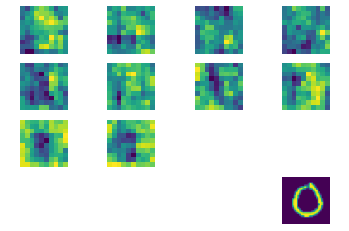

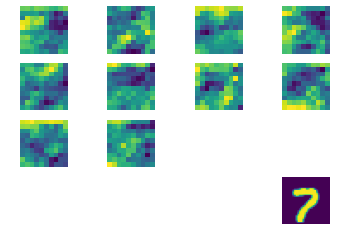

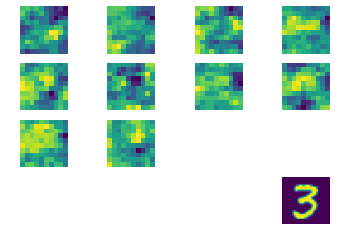

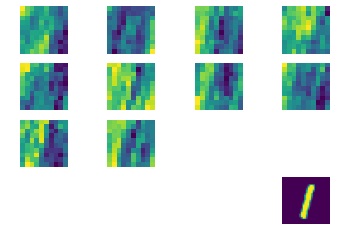

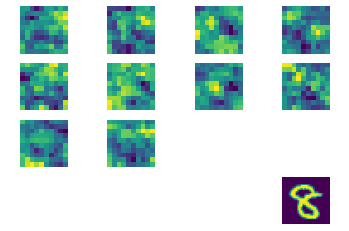

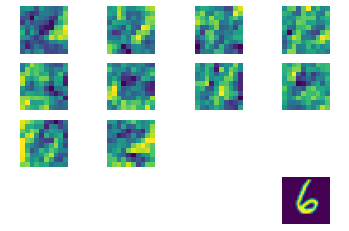

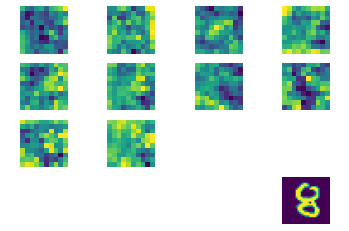

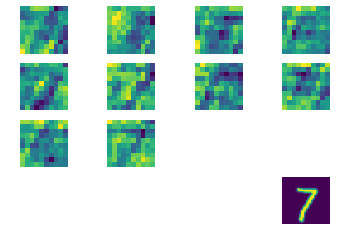

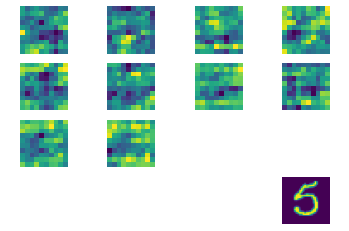

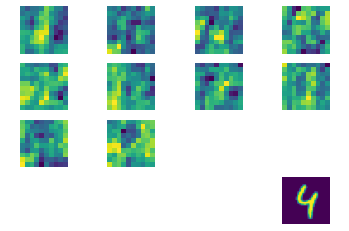

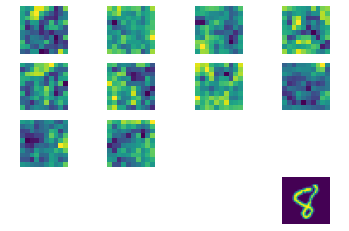

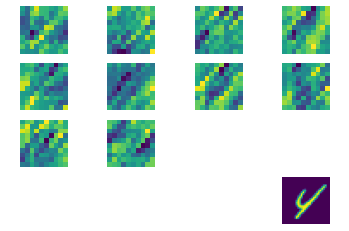

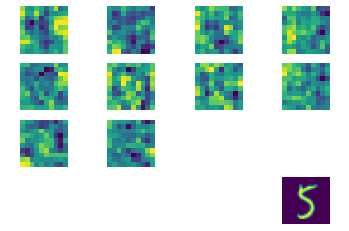

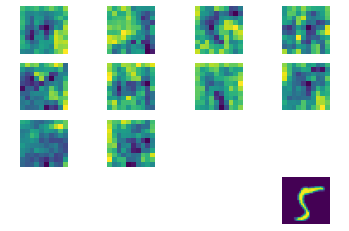

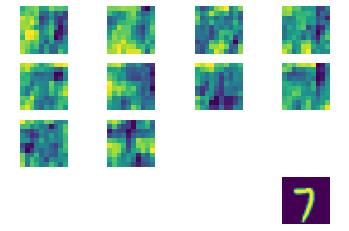

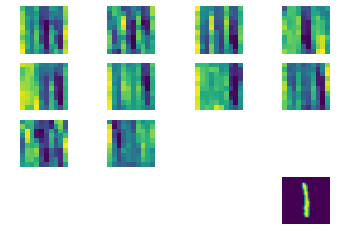

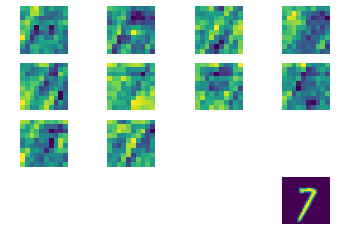

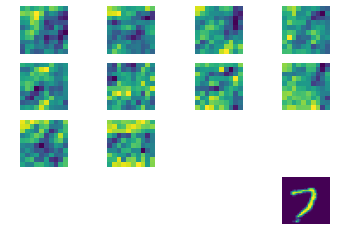

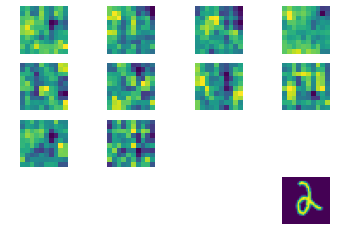

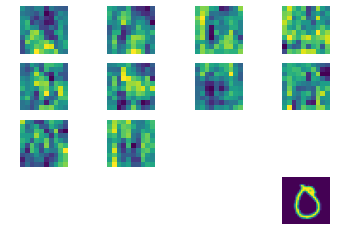

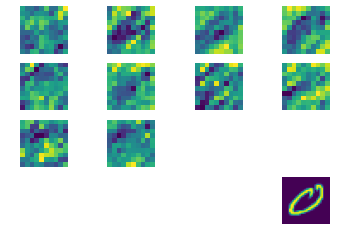

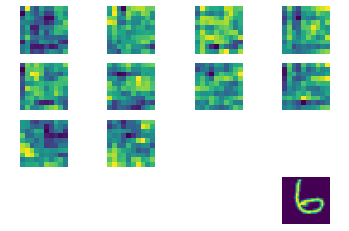

In [78]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


import sys
sys.path.insert(0, "helper")
sys.path.insert(0, "/helper")
sys.path.insert(0, "./helper")
sys.path.insert(0, "../helper")
print(sys.path)

# own module
from visualisation.feature_map import *



class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = Conv2d(1, 32, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv3 = Conv2d(64, 128, kernel_size=3, stride=1, padding=0, dilation=3)
        self.conv1x1 = Conv2d(128, 10, kernel_size=1, stride=1, padding=0, dilation=1)
        #self.dropout1 = nn.Dropout(0.25)
        #self.dropout2 = nn.Dropout(0.5)
        # 4x16384
        #self.fc1 = nn.Linear(10*10*10, 10)
        # self.fc2 = nn.Linear(10, 10)
        
        self.flat = nn.Flatten()

    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        x = self.conv3(x)
        x = F.relu(x)
        
        x = self.conv1x1(x)
        x = F.relu(x)
        
        # print(x.shape)
        
        #x = F.max_pool2d(x, 2)
        #x = self.dropout1(x)
        
        #print(x.size())
        #print(x.size()[2:])
        
        x = F.max_pool2d(x, kernel_size=x.size()[2:])
        
        x = self.flat(x)
        
        output = F.sigmoid(x)
        
        #x = torch.flatten(x, 1)
        #x = self.fc1(x)
        #x = F.relu(x)
        
        #x = self.dropout2(x)
        #x = self.fc2(x)
        #output = F.log_softmax(x, dim=1)
        return output



def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        
        
        
        data, target = data.to(device), target.unsqueeze(1) # .to(device)
        optimizer.zero_grad()
        output = model(data)
        
        
        
        
        target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
        
        if batch_idx == -1:
            print(data.shape) # torch.Size([4, 1, 28, 28])
            print(target)
            """
            tensor([[8],
            [7],
            [2],
            [7]])
            """
            print(target_multi_hot)
            """
            tensor([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
            [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
            [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
            """
            
            


        
        
        loss = F.binary_cross_entropy(output, target_multi_hot)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.unsqueeze(1) # .to(device)
            
            output = model(data)
            
            target_multi_hot = torch.zeros(target.size(0), 10).scatter_(1, target, 1.).to(device)
            test_loss += F.binary_cross_entropy(output, target_multi_hot, reduction='mean').item()
        
            # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.to(device).view_as(pred)).sum().item()
            
            if i == 0:
                print(data.shape)
                layer = model.conv1x1 # model.conv1[0] # model.stage2[0].branch1[2] # model.fusion_layer # conv
                # run feature map
                dd = FeatureMap(model=model, layer=layer, device=device, iterations=None, lr=None)
                dd.run(data)
                dd.plot()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

class Parser():
    
    def __init__(self):
        self.batch_size = 16
        self.test_batch_size = 1
        self.epochs = 100
        self.lr = 0.001
        self.gamma = 0.7
        self.log_interval = 1000
        self.save_model = False
        

def main():
    # Training settings
    args = Parser()
    
    if True:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if device == torch.device("cuda"):
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()
        
        
        
        


    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")



main()

In [57]:
import torch

batch_size = 3
num_classes = 10

loss_fn = torch.nn.BCELoss()

outputs_before_sigmoid = torch.randn(batch_size, num_classes)
sigmoid_outputs = torch.sigmoid(outputs_before_sigmoid)

# classes = [[2, 4, 7], [3, 6, 9]]
labels = torch.tensor([[1], [9], [4]])
# labels = labels.unsqueeze(0)
target_classes = torch.zeros(labels.size(0), 10).scatter_(1, labels, 1.)


# target_classes = torch.randint(0, 2, (batch_size, num_classes)).to(torch.float32)  # randints in [0, 2).

loss = loss_fn(sigmoid_outputs, target_classes)

# alternatively, use BCE with logits, on outputs before sigmoid.
loss_fn_2 = torch.nn.BCEWithLogitsLoss()
loss2 = loss_fn_2(outputs_before_sigmoid, target_classes)

print(sigmoid_outputs)

print(target_classes)

print(loss)
print(loss2)

tensor([[0.5565, 0.5814, 0.4714, 0.9196, 0.2232, 0.3252, 0.6089, 0.6566, 0.5629,
         0.8550],
        [0.6878, 0.6854, 0.1971, 0.7730, 0.5326, 0.9440, 0.3586, 0.7567, 0.7658,
         0.8077],
        [0.4075, 0.6718, 0.9110, 0.3599, 0.4434, 0.1463, 0.3008, 0.5302, 0.3500,
         0.1679]])
tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])
tensor(0.9439)
tensor(0.9439)


In [69]:
labels = torch.tensor([1, 0, 5, 2])
labels = labels.unsqueeze(0)

target = torch.zeros(labels.size(0), 10).scatter_(1, labels, 1.)
print(target)
print(labels)

tensor([[1., 1., 1., 0., 0., 1., 0., 0., 0., 0.]])
tensor([[1, 0, 5, 2]])


In [ ]:
t = torch.empty(3, 4, 5)
t.size()

t.size(dim=1)

In [ ]:
len(t)

In [ ]:
64*16*16

In [ ]:
12800/128


In [ ]:
np.sqrt(100)